# Intensity and spatial features from CSLs for VAE_all

## Extract features for all experiments of the perturbation dataset
```
scripts/extract_features.sh
```

This extracts:
- per cluster mean intensity feature
- per cluster pair co-occurence scores
    - Co-occurrence scores are extracted with logarithmically growing distances, with 20 intervals, up to the maximum distance of 80 pixels
- per cluster and connected component statistics
    - computed statistics are: area, circularity, extent and elongation

The features are saved in an anndata object per data directory:
- `features.h5ad` containing features using the original clustering
- `features_annotation.h5ad` containing features using the annotated clustering

Note that the calculation of co-occurrence scores is time and memory intensive. 
You can adjust the CO_OCC_CHUNK_SIZE value if the processes runs out of memory, and run the feature extraction with multiple processes to speed the computation up.

# Explore features
In the following, we plot intensity, co-occurence, and object features using plotting function provided in campa.pl

We use `features_annotation.h5ad`, for plotting results on the original clustering, replace this with `features.h5ad`

In [1]:
from campa.tl import Experiment, FeatureExtractor
import os
from campa.pl import plot_mean_intensity, get_intensity_change, plot_intensity_change, plot_mean_size, plot_size_change, plot_object_stats
from campa.pl import plot_co_occurrence, plot_co_occurrence_grid
import anndata as ad
from campa.utils import init_logging
import logging
init_logging(level=logging.WARNING)

In [2]:
exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
features_fname = 'features_annotation.h5ad'

# load extracted features for clustering_res0.5, annotation
extrs = [FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, features_fname)) for data_dir in exp.data_params['data_dirs']]


## Mean and per cluster intensity

In [3]:
# get combined adata for dotplots
adatas = [extr.get_intensity_adata() for extr in extrs]
adata = ad.concat(adatas, index_unique='-')

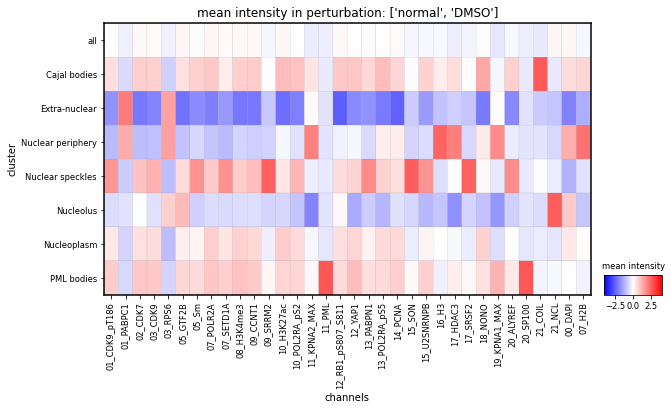

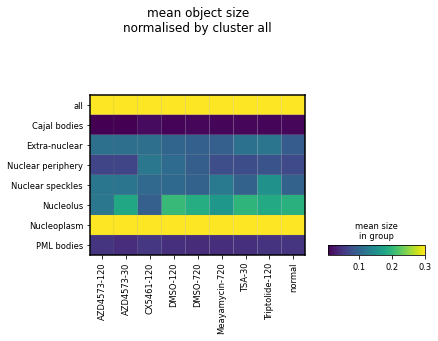

In [4]:
plot_mean_intensity(adata, groupby='cluster', limit_to_groups={'perturbation':['normal', 'DMSO']}, dendrogram=False, layer=None, 
    standard_scale='var', cmap='bwr', vmin=-4, vmax=4)
plot_mean_size(adata, groupby_row='cluster', groupby_col='perturbation_duration', normby_row='all', vmax=0.3)

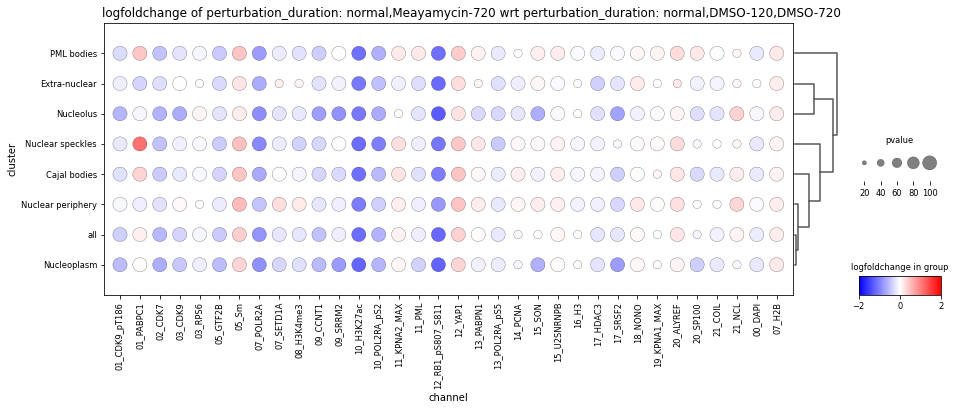

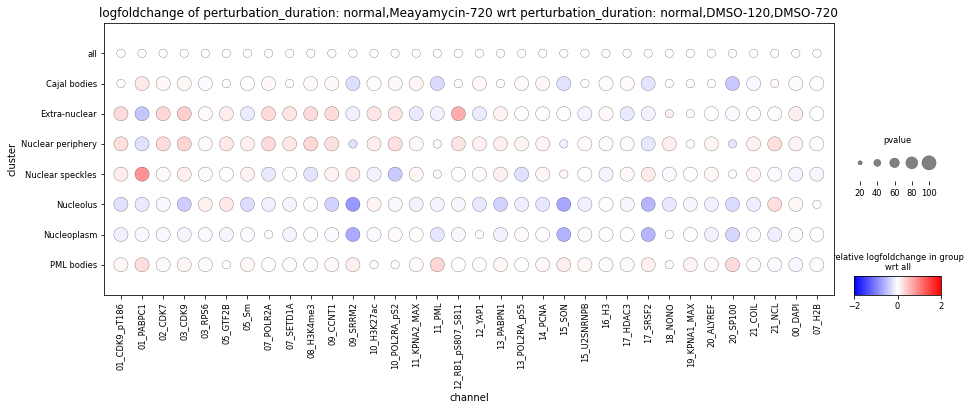

In [5]:
res = get_intensity_change(adata, groupby='cluster', reference_group='perturbation_duration', reference=['normal','DMSO-120', 'DMSO-720'], 
    limit_to_groups={'perturbation_duration': ['normal', 'Meayamycin-720']}, color='logfoldchange', size='pval')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2, dendrogram=True)

res = get_intensity_change(adata, groupby='cluster', reference_group='perturbation_duration', reference=['normal','DMSO-120', 'DMSO-720'], 
    limit_to_groups={'perturbation_duration': ['normal', 'Meayamycin-720']}, color='logfoldchange', size='pval', norm_by_group='all')
plot_intensity_change(**res, adjust_height=True, figsize=(15,5), vmin=-2, vmax=2)

## Co-occurrence scores

In [6]:
# get combined adata for co-occurrence
adata_co_occ = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')

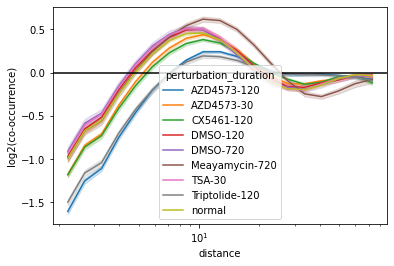

In [7]:
# for one cluster-cluster pairing
plot_co_occurrence(adata_co_occ, 'Nuclear speckles', 'PML bodies', 'perturbation_duration', condition_values=None)

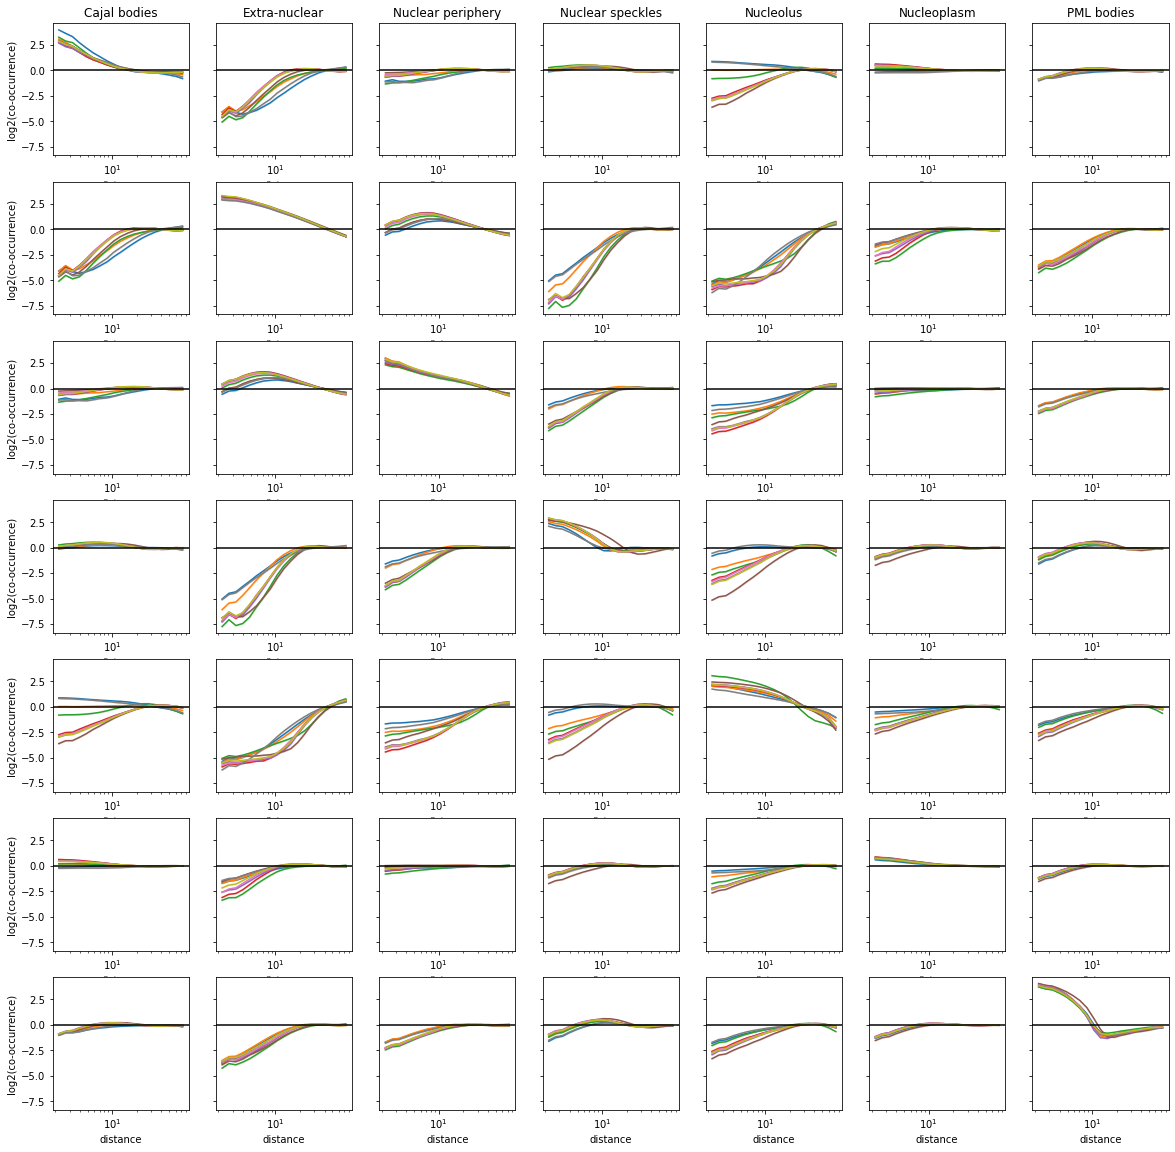

In [8]:
# for all cluster pairings
fig, axes = plot_co_occurrence_grid(adata_co_occ, 'perturbation_duration', condition_values=None, legend=False, ci=False, figsize=(20,20))

## Object statistics

In [3]:
# aggregate object statistics
for extr in extrs:
    _ = extr.get_object_stats(area_threshold=10, agg=['median'])
# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs], index_unique='-', uns_merge='same')


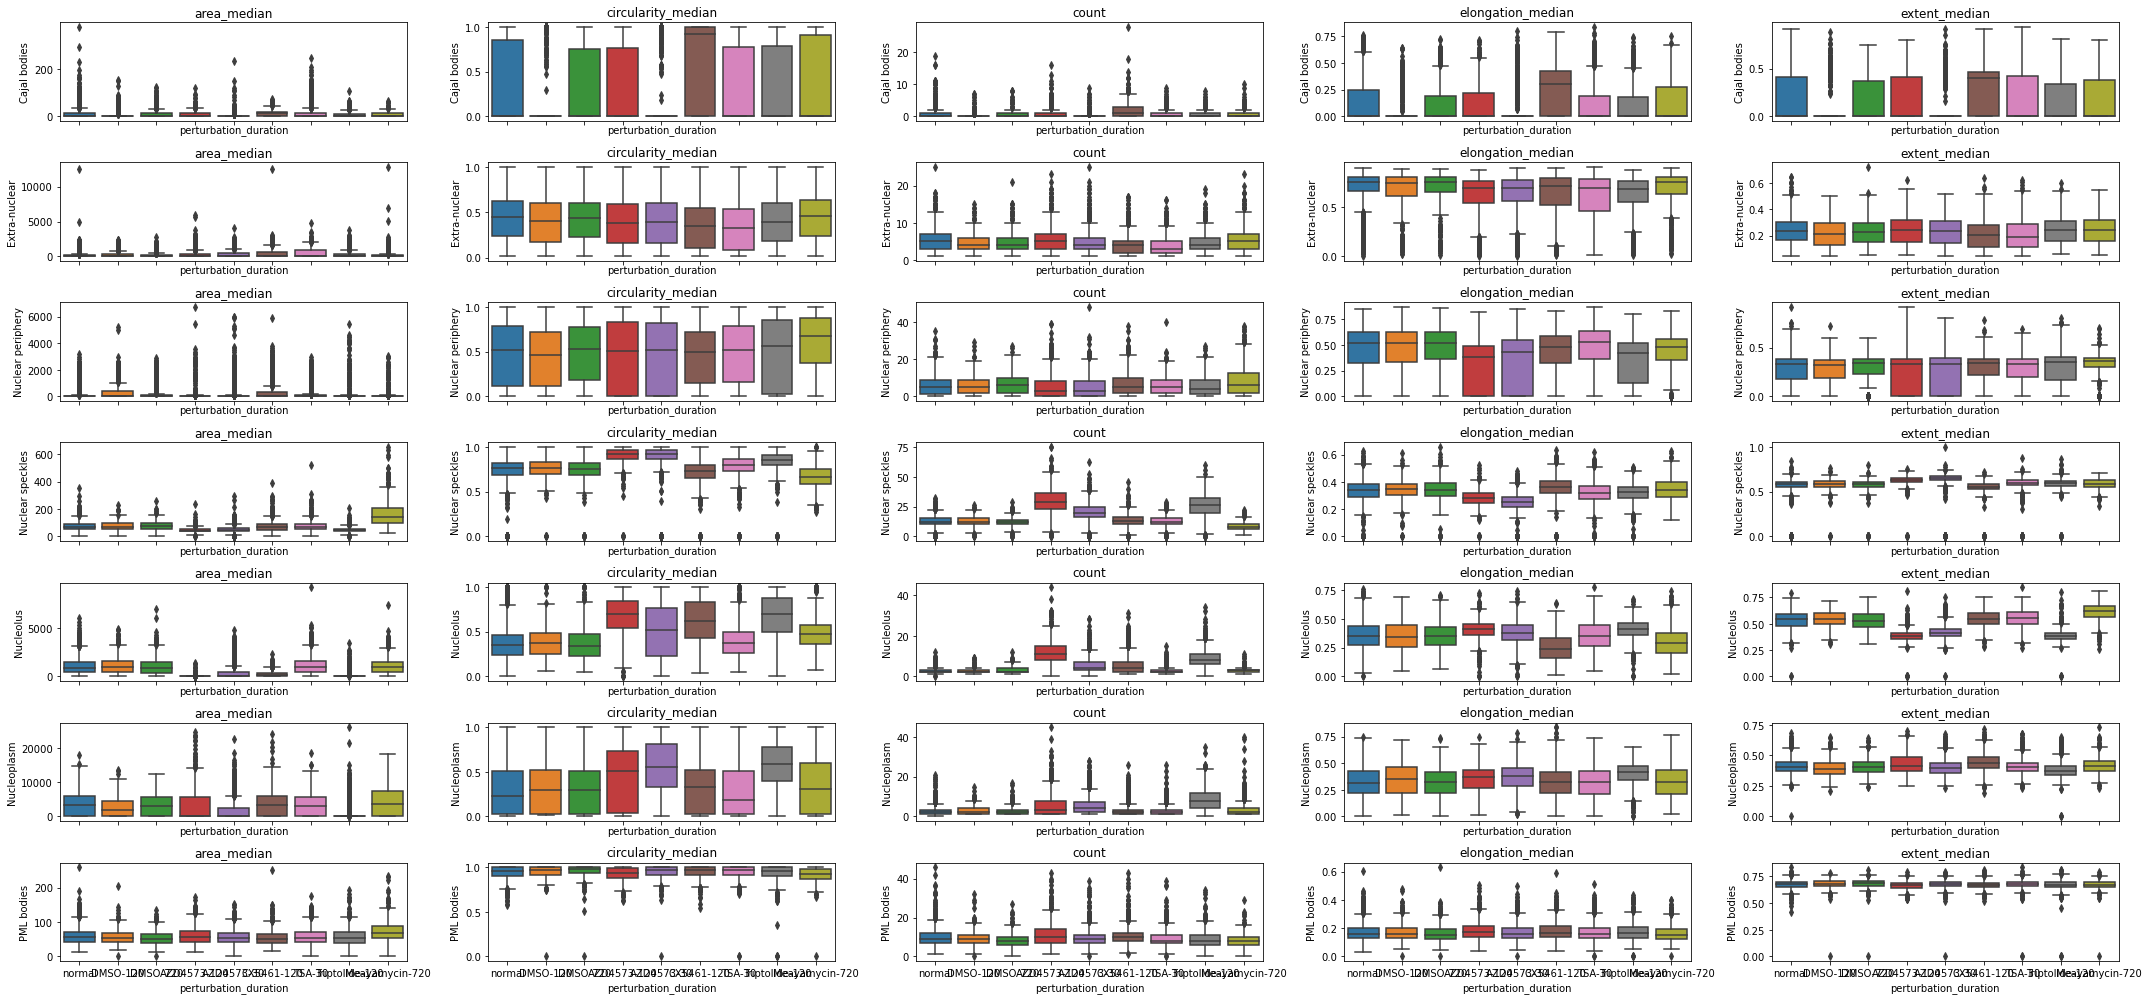

In [5]:
plot_object_stats(adata_object_stats, group_key='perturbation_duration', figsize_mult=(6,2))

## Export calculated features as csv
For each feature type (intensity, object statistics, and co-occurrence scores), the data can be extracted as a csv.
* intensity: one csv file named `intensity_{extr.fname}.csv` is stored, containing mean intensity and size features
* co-occurrence scores: one file per cluster-cluster pair named `co_occ_{cluster1}_{cluster2}_{extr.fname}.csv` is stored, containing co-occurrence scores at all distance intervals.
* per object stats: one csv file named `object_stats_{extr.fname}.csv` is stored, containing object stats. Note that this only works, if object stats were aggregated to per-cell level using `extr.get_object_stats`

Each export function also takes obs column names as input which it additionally appends to the exported csv.


In [1]:
from campa.tl import Experiment, FeatureExtractor, thresholded_count, thresholded_median
import os

exp = Experiment.from_dir('VAE_all/CondVAE_pert-CC')
for data_dir in exp.data_params['data_dirs']:
    # clusters
    #extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features.h5ad'))
    #extr.extract_intensity_csv(obs=['well_name', 'perturbation_duration', 'TR'])

    # annotated clusters
    extr = FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_annotation.h5ad'))
    #extr.extract_intensity_csv(obs=['well_name', 'perturbation_duration', 'TR'])
    #extr.extract_co_occurrence_csv(obs=['well_name', 'perturbation_duration', 'TR'])
    # ensure that aggregated object stats are present
    _ = extr.get_object_stats(area_threshold=10, agg=['median', thresholded_count, thresholded_median])
    extr.extract_object_stats_csv(obs=['well_name', 'perturbation_duration', 'TR'])

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


/Users/hannah.spitzer/opt/miniconda3/envs/campa/lib/python3.9/site-packages/docrep/decorators.py:43: SyntaxWarning: 'plotting' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
